# Load data

## Read data

In [1]:
library(tidyverse)
library(Seurat)
library(sf)
library(anndata)
set.seed(42)

Warning message:
"package 'ggplot2' was built under R version 4.3.1"
Warning message:
"package 'dplyr' was built under R version 4.3.1"
Warning message:
"package 'stringr' was built under R version 4.3.1"
-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.1     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: SeuratObject

Warning message:
"package 'SeuratObject' was built under R version 4.3.1"
Loading required package: sp

'SeuratObject' was built with package 'Matrix' 1.6.3 but the current
version is 1.6.4; it is recomended that you reinstall 'Seu

In [2]:
## read sc counts from MS1 (there are three)
sc_mtx <- Read10X_h5('../original_data/single_cell/Kidney_MS_1.h5')

## read srt counts
srt_mtx <- Matrix::readMM('../original_data/male_cartana/male_ctx.mtx')
rownames(srt_mtx) <- read.csv('../original_data/male_cartana/male_genes.csv', 
                              header = F) %>% 
  pull(V1)
colnames(srt_mtx) <- read.csv('../original_data/male_cartana/male_cells.csv', 
                              header = F) %>% 
  pull(V1)
## read srt metadata
srt_meta <- read.csv('../original_data/male_cartana/male_meta.csv') %>% 
  select(!X)

## Subset data

There are areas with NAs, since we rely on the area to simulate the diffusion, I removed these cells.

[1] 134

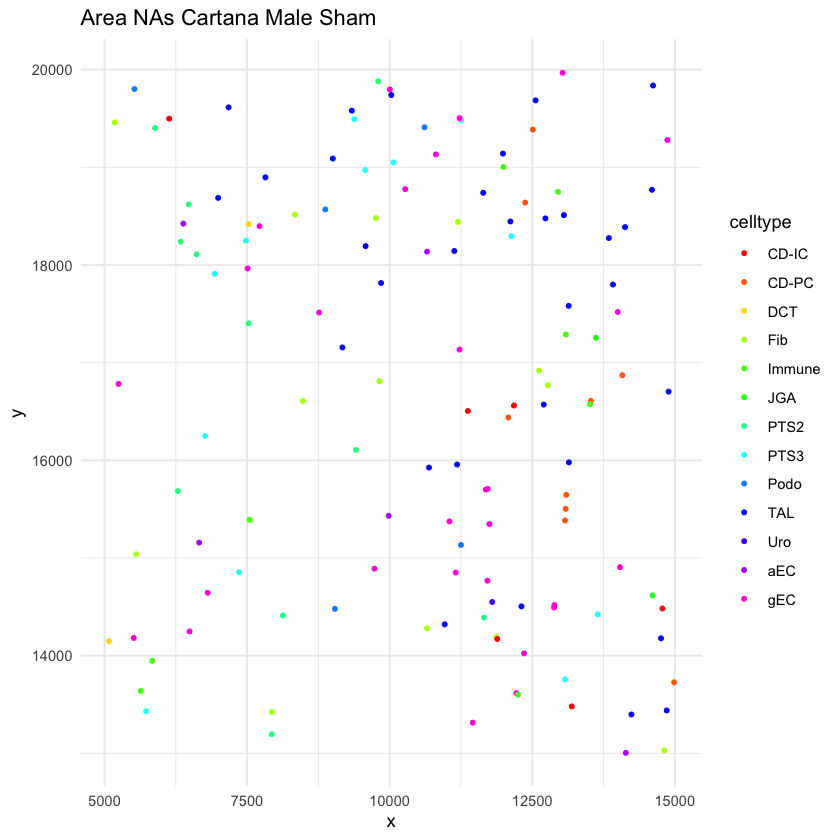

In [3]:
## select smaller sample to be compatible with the number of scs
sub_srt_meta <- srt_meta %>% 
  filter(x < 15000, y < 20000,
         x > 5000, y > 13000)

## check area nas, 134 cells
sum(is.na(sub_srt_meta$area))
## check if it is evenly spread
sub_srt_meta[is.na(sub_srt_meta$area), ] %>% 
  ggplot() +
  geom_point(aes(x, y, color = celltype), size = 1) +
  scale_color_manual(values = rainbow(14)) +
  guides(colour = guide_legend(override.aes = list(size=1))) + 
  labs(title = 'Area NAs Cartana Male Sham') + 
  theme_minimal()
## remove area nas
sub_srt_meta <- sub_srt_meta %>% 
  drop_na(area)

There are also cells with small areas that need to be removed.

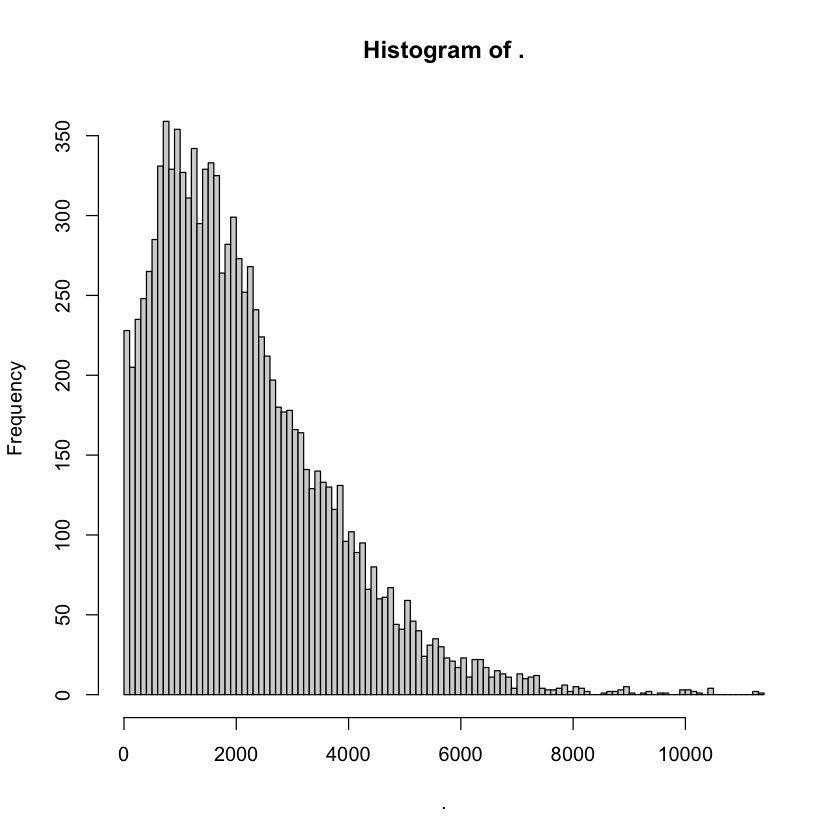

In [4]:
## check area sizes, some cells have low values
sub_srt_meta$area %>% hist(breaks = 100)

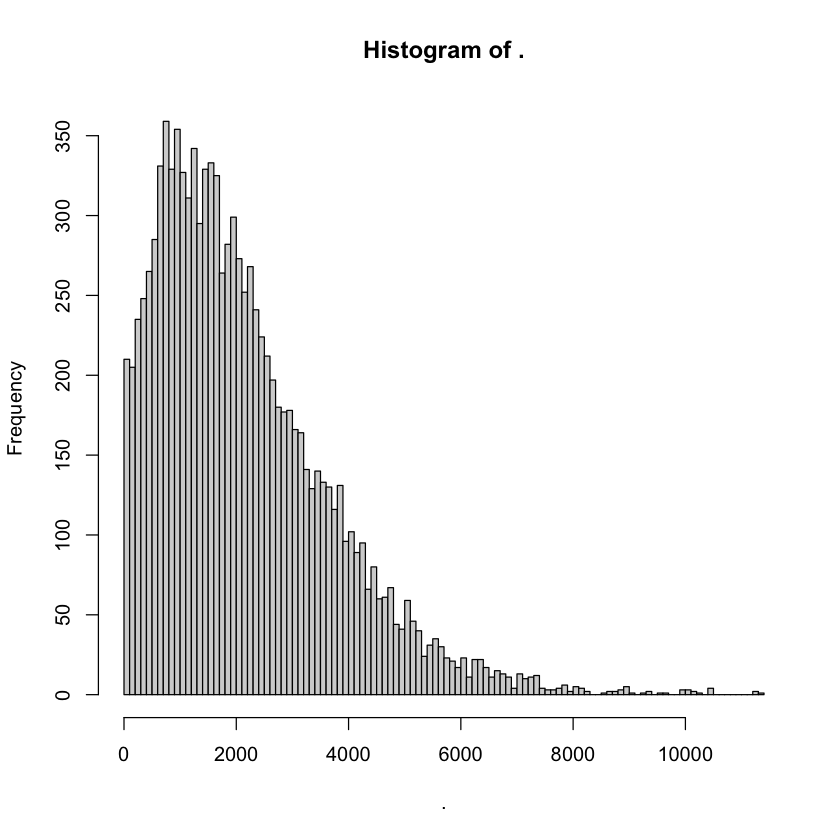

In [5]:
## filter area >= 10
sub_srt_meta %>% 
  filter(area >= 10) %>% 
  pull(area) %>% 
  hist(breaks = 100)

[1] 18

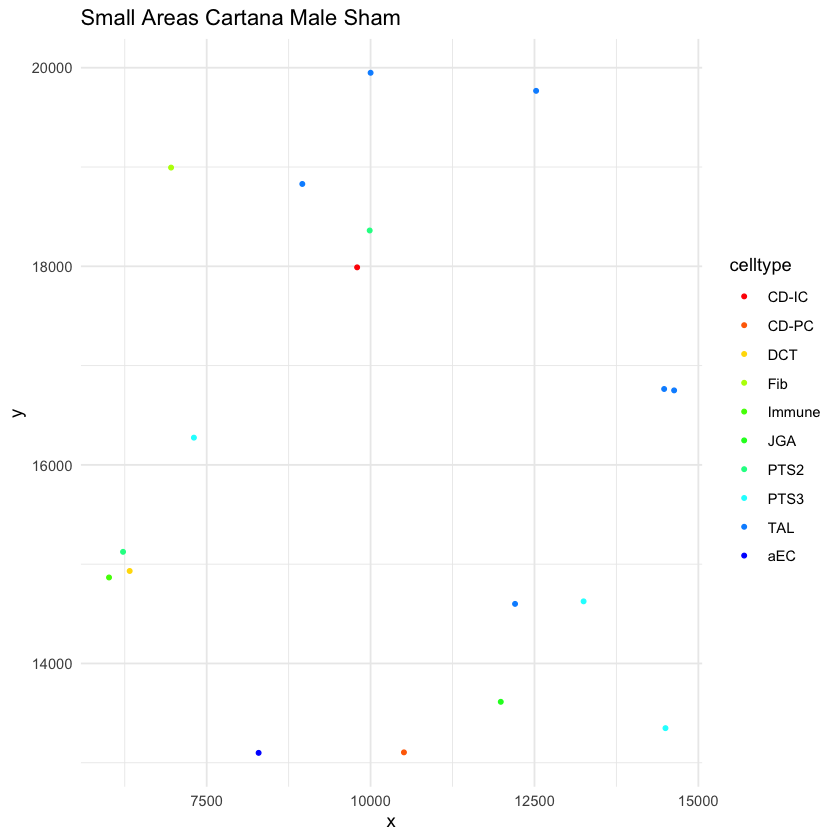

In [6]:
## 18 cells
sum(sub_srt_meta$area < 10)
sub_srt_meta %>% 
  filter(area < 10) %>% 
  ggplot() +
  geom_point(aes(x, y, color = celltype), size = 1) +
  scale_color_manual(values = rainbow(14)) +
  guides(colour = guide_legend(override.aes = list(size=1))) + 
  labs(title = 'Small Areas Cartana Male Sham') + 
  theme_minimal()
## remove small areas
sub_srt_meta <- sub_srt_meta %>% 
  filter(area >= 10)

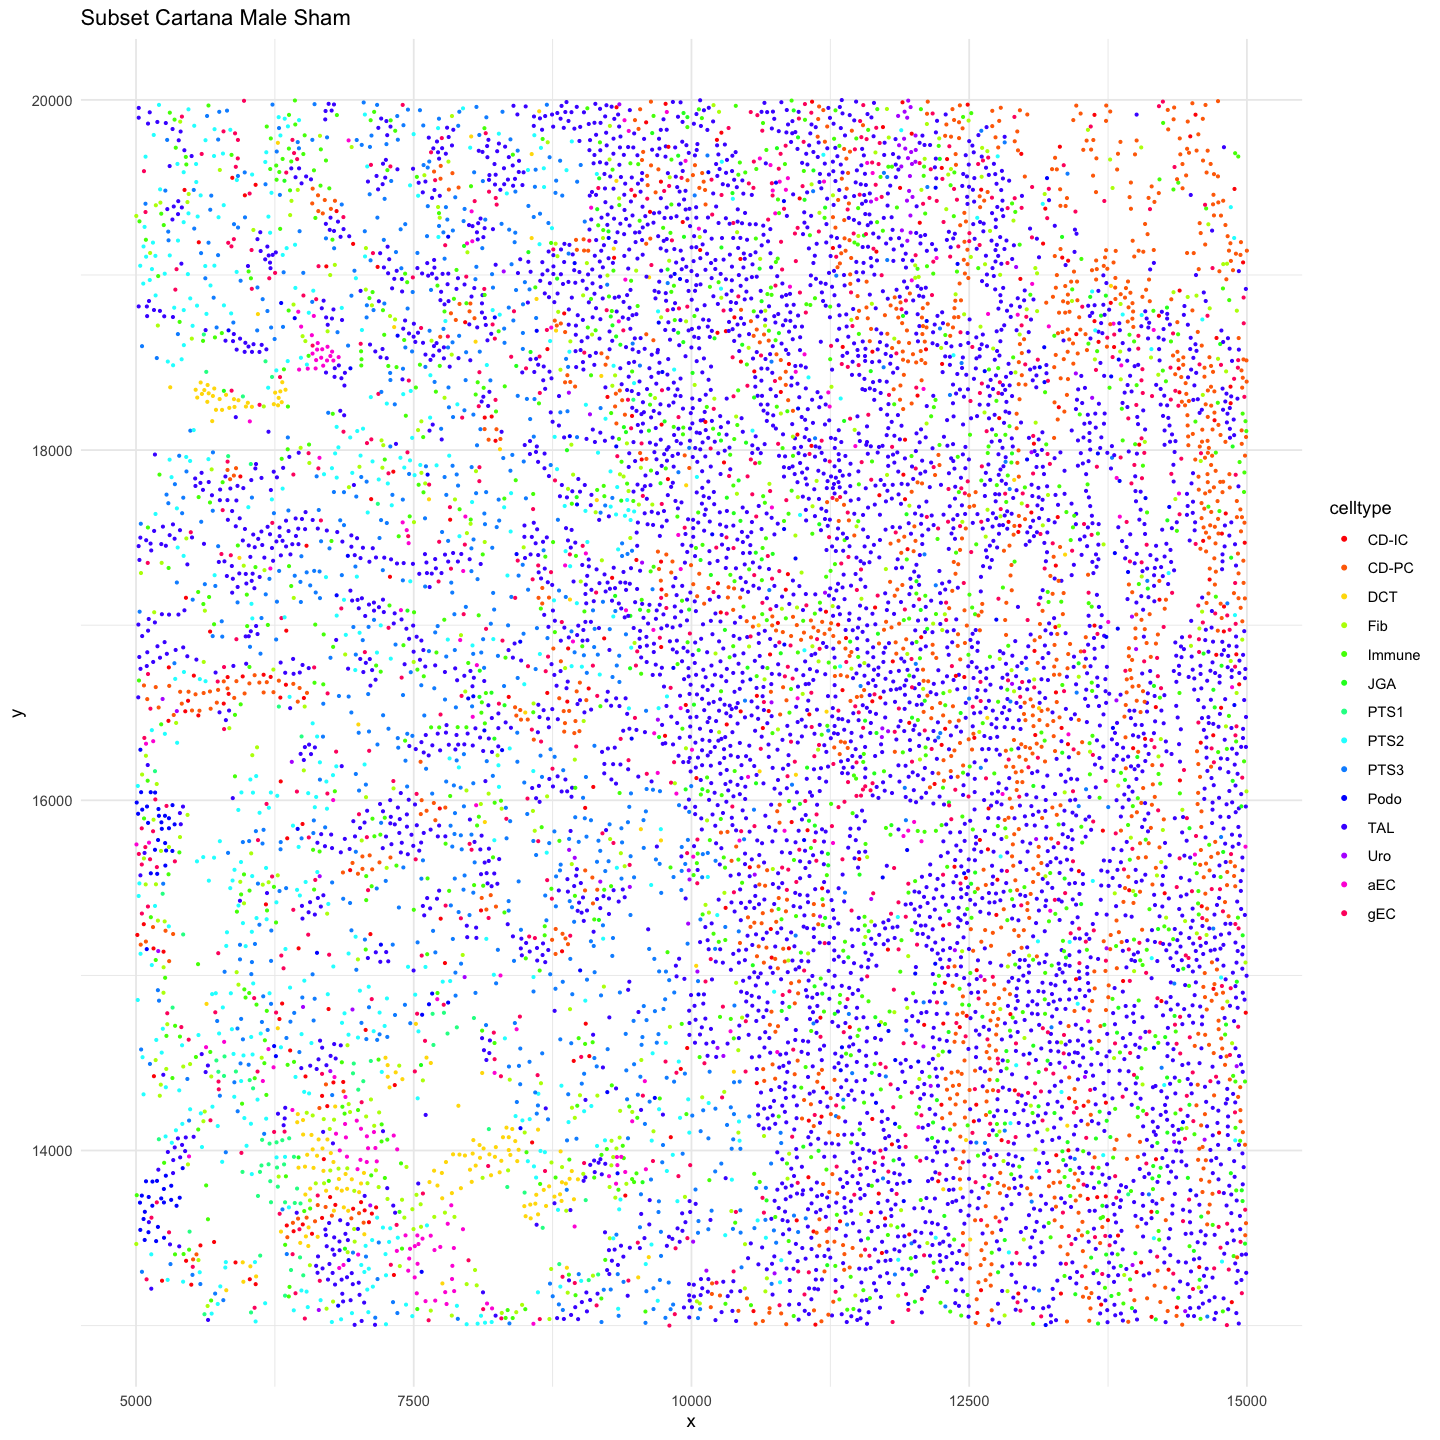

In [7]:
options(repr.plot.width = 12, repr.plot.height = 12)

sub_srt_meta %>% 
  ggplot() +
  geom_point(aes(x, y, color = celltype), size = .5) +
  scale_color_manual(values = rainbow(14)) +
  guides(colour = guide_legend(override.aes = list(size=1))) + 
  labs(title = 'Subset Cartana Male Sham') + 
  theme_minimal()

In [8]:
## select common genes to measure similarity
srt_genes <- rownames(srt_mtx)
sc_genes <- rownames(sc_mtx)
common_genes <- intersect(srt_genes, sc_genes)

## filter data
f_sc_mtx <- sc_mtx[common_genes, ]
f_srt_mtx <- srt_mtx[common_genes, ]

In [9]:
## some cells from the sc data don't express any of the common genes, remove them
sc_cg_exp <- which(colSums(f_sc_mtx) != 0)
s_sc_mtx <- f_sc_mtx[, sc_cg_exp]

In [10]:
## subset srt matrix
s_srt_mtx <- f_srt_mtx[, sub_srt_meta$cell]

# Integrate datasets

The idea is to have a more representative way to assign the position to the single cells. I tried spaotsc and cytospace, but both didn't work. I tried mapping using seurat FindTransferAnchors and MapQuery functions, but it also didn't work. So I integrated the datasets to remove batch effects and looked for the most similar cells in this integrated space.

In [11]:
## create Seurat objects
sc_seurat <- CreateSeuratObject(counts = s_sc_mtx, project = "sc_sample")
srt_seurat <- CreateSeuratObject(counts = s_srt_mtx, project = "srt_sample")
seurat_obj <- merge(sc_seurat, y = srt_seurat, add.cell.ids = c("sc_sample", "srt_sample"))

Warning message:
"Data is of class dgTMatrix. Coercing to dgCMatrix."


In [12]:
## preprocess
seurat_obj <- NormalizeData(seurat_obj)
seurat_obj <- FindVariableFeatures(seurat_obj)
seurat_obj <- ScaleData(seurat_obj)
seurat_obj <- RunPCA(seurat_obj)

Normalizing layer: counts.sc_sample

Normalizing layer: counts.srt_sample

Finding variable features for layer counts.sc_sample

Finding variable features for layer counts.srt_sample

Centering and scaling data matrix

Warning message:
"The following 1 features requested have zero variance; running reduction without them: Atp10b"
PC_ 1 
Positive:  Pecam1, Flt1, Emcn, Podxl, Ehd3, Cd34, Vim, Fas, Entpd1, Tgfb1 
	   Cd38, Cav1, Cldn5, Edn1, Ly6e, Eln, Zeb2, Serpine1, Vcam1, Gja5 
	   Plxna2, Snai2, Pdgfrb, Il3ra, Des, Tagln, Acta2, Itga8, Slit3, Cd274 
Negative:  Umod, Egf, Cdh1, Epcam, Vegfa, Slc12a3, Slc12a1, Slc5a2, Slc5a12, Calb1 
	   Inmt, Ctsd, Aqp2, Scel, Foxi1, Slc26a4, Cftr, Folr2, Cdh2, Atp6v1g3 
	   Aqp4, Slc7a12, Sfta2, Havcr1, Kit, Cyp2f2, Gsta1, Rnf24, Scgb1a1, Arg1 
PC_ 2 
Positive:  Slc5a2, Slc5a12, Ctsd, Inmt, Tubb4b, Plin2, Vegfa, Wnk1, Apoe, Zeb2 
	   Plxna2, Stat3, Cdh2, Stmn1, Atp6v1g3, Calb1, Cftr, Ly6e, Bcl2, Cav1 
	   Rnf24, Slc26a4, Slc12a3, Kit, Foxi1, Dgkb, Edn

In [13]:
seurat_obj <- IntegrateLayers(object = seurat_obj, method = CCAIntegration, 
    orig.reduction = "pca", new.reduction = "integrated.cca", verbose = FALSE)

# re-join layers after integration
seurat_obj[["RNA"]] <- JoinLayers(seurat_obj[["RNA"]])

seurat_obj <- FindNeighbors(seurat_obj, reduction = "integrated.cca", dims = 1:30)
seurat_obj <- FindClusters(seurat_obj, resolution = 1)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 22043
Number of edges: 778262

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8968
Number of communities: 45
Elapsed time: 1 seconds


In [14]:
## viz integration
seurat_obj <- RunUMAP(seurat_obj, dims = 1:30, reduction = "integrated.cca")

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
16:54:01 UMAP embedding parameters a = 0.9922 b = 1.112

16:54:01 Read 22043 rows and found 30 numeric columns

16:54:01 Using Annoy for neighbor search, n_neighbors = 30

16:54:01 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

16:54:03 Writing NN index file to temp file /var/folders/q5/1r2zbyjd3mj5dg4910xgdkjc0000gn/T//RtmpdPTdy5/file58d71ede0666

16:54:03 Searching Annoy index using 1 thread, search_k = 3000

16:54:07 Annoy recall = 99.87%

16:54:07 Commencing smooth kNN distance calib

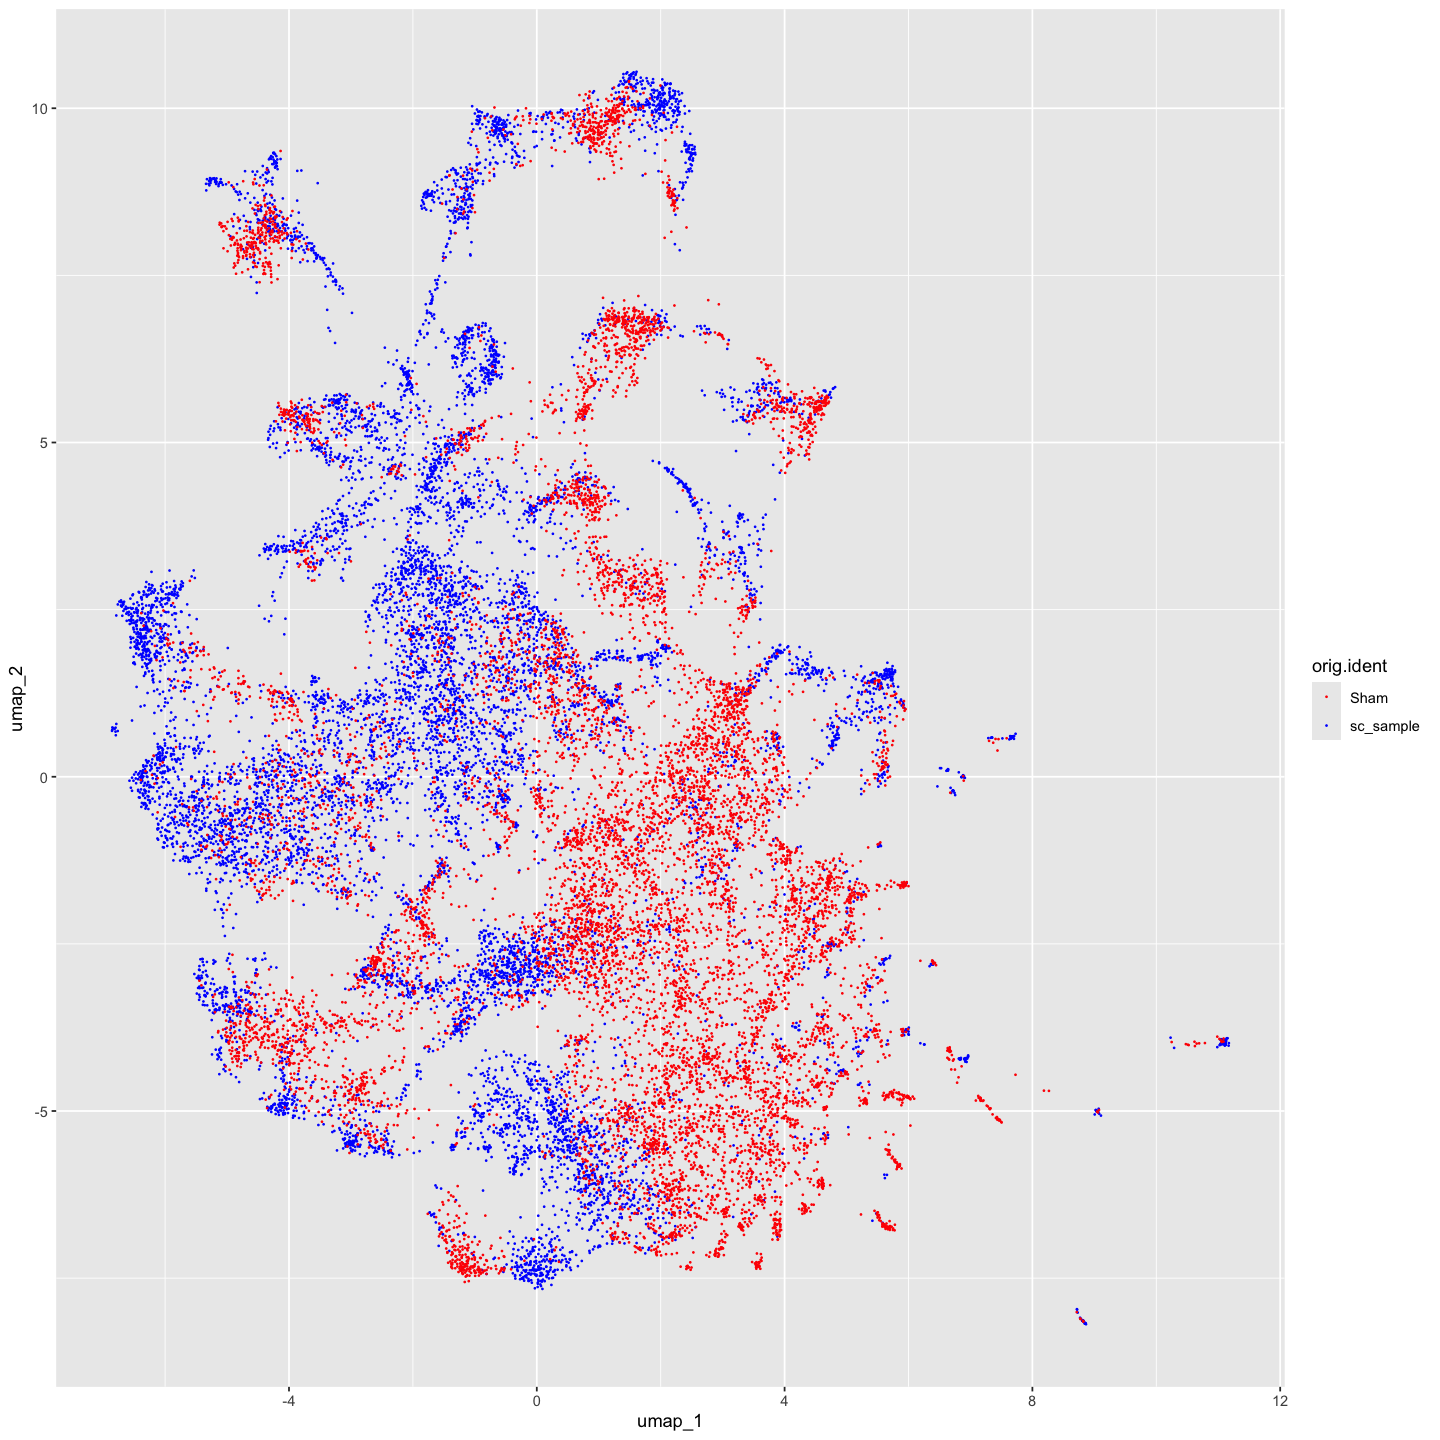

In [15]:
df_meta <- seurat_obj@meta.data
df_umap <- as.data.frame(seurat_obj@reductions$umap@cell.embeddings)
df_meta <- merge(df_meta, df_umap, by = 0)

df_meta %>% 
    ggplot() +
    geom_point(aes(umap_1, umap_2, color = orig.ident), size = .1) +
    scale_color_manual(values = c('red', 'blue'))

Integration could be better.

# Assign positions

Given a cell from the spatial data, calculate which cell from the single-cell data is the most similar to it and assign the spatial position to the single cell.

In [ ]:
cca_mtx <- seurat_obj@reductions$integrated.cca@cell.embeddings
sc_cca <- cca_mtx[which(grepl("^sc_sample", rownames(cca_mtx))), ]
srt_cca <- cca_mtx[which(grepl("^srt_sample", rownames(cca_mtx))), ]

In [ ]:
## calculate distance
dist_matrix <- proxy::dist(srt_cca, sc_cca, method = "euclidean")
dist_matrix <- as.matrix(dist_matrix)

In [18]:
dist_matrix[1:5, 1:5]

,sc_sample_AAACCCAAGGTAAGGA-1,sc_sample_AAACCCAAGTCCCAAT-1,sc_sample_AAACCCACACCCTTGT-1,sc_sample_AAACCCACACCGGAAA-1,sc_sample_AAACCCACAGACGGAT-1
srt_sample_Sham_8283,18.34827,9.756744,8.942707,7.973546,15.47818
srt_sample_Sham_8317,19.34955,8.213575,7.383283,7.231843,14.55497
srt_sample_Sham_8505,19.47159,8.964300,5.599080,7.687758,16.08537
srt_sample_Sham_8568,19.76757,9.034888,7.055628,7.208831,15.36755
srt_sample_Sham_8619,19.54507,9.406549,7.830685,7.206022,15.06313


In [19]:
## assign cells from one df to the other based on the distance
## this algorithm os O(n^3) and it was taking too long (>1300 min)
# assign <- clue::solve_LSAP(dist_matrix)

In [ ]:
## get srt cells with the least distance to the sc cells
## uniqueness not guaranteed
mapping <- apply(dist_matrix, 2, FUN = function(c) {names(which.min(c))} )

In [ ]:
## check how many were unique, the srt dataset has 10770 cells
length(unique(mapping))

[1] 2767

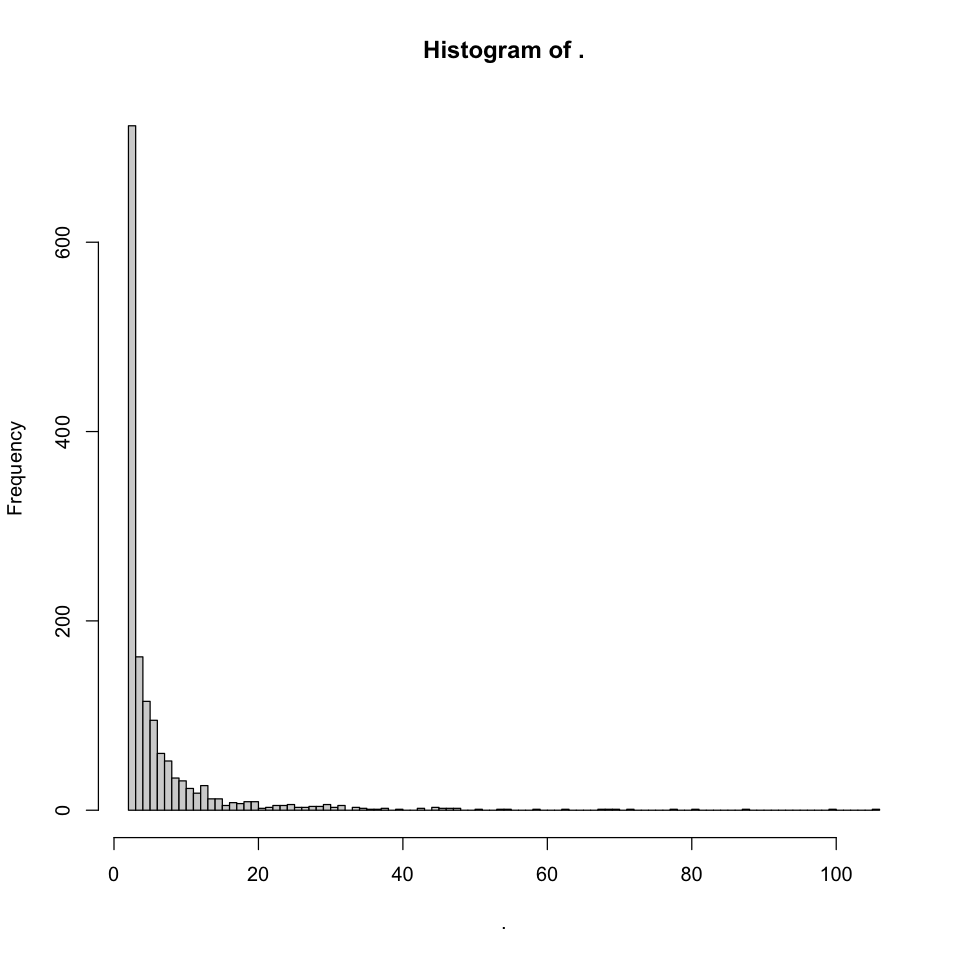

In [50]:
## check the distribution of repeats
options(repr.plot.width = 8, repr.plot.height = 8)
table(mapping)[table(mapping) > 1] %>% hist(breaks = 100)

In [87]:
## get mapping
sc_cells <- sapply(names(mapping), FUN = function(s) {str_split(s, 'sc_sample_')[[1]][2]})
srt_cells <- sapply((mapping), FUN = function(s) {str_split(s, 'srt_sample_')[[1]][2]})

In [117]:
## create metadata for sc
df_rows <- list()
for (i in 1:length(sc_cells)) {
    meta_row <- srt_meta[which(srt_meta$cell == srt_cells[i]), ]
    df_rows[[i]] <- list(sc_cells[[i]][[1]], meta_row$x, meta_row$y, meta_row$elongation, meta_row$area, srt_cells[[i]][[1]])
}

sc_meta <- as.data.frame(do.call(rbind, df_rows))
colnames(sc_meta) <- c('cell', 'x', 'y', 'elongation', 'area', 'srt_cell')
sc_meta <- sc_meta %>% 
    mutate(cell = as.character(cell), x = as.numeric(x), y = as.numeric(y),
    elongation = as.numeric(elongation), area = as.numeric(area), srt_cell = as.character(srt_cell))

In [118]:
head(sc_meta)

,cell,x,y,elongation,area,srt_cell
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,AAACCCAAGGTAAGGA-1,6589.351,18596.79,2.833,1390.0,Sham_21413
2,AAACCCAAGTCCCAAT-1,6706.731,13677.54,4.263,1565.0,Sham_11856
3,AAACCCACACCCTTGT-1,6332.787,13920.69,1.300,1403.0,Sham_11605
4,AAACCCACACCGGAAA-1,5329.179,14816.21,33.140,517.4,Sham_11383
5,AAACCCACAGACGGAT-1,12377.961,19690.29,1.846,6045.0,Sham_38551
6,AAACCCACAGTCGGTC-1,13846.138,18517.05,5.112,378.9,Sham_39301


In [120]:
write.csv(sc_meta, '../sim_data/prox_assign/sc_meta.csv')